# Classification

In [1]:
import numpy as np
import matplotlib.pyplot as plt

import torch
from pytorch_lightning import LightningModule, LightningDataModule, Trainer
from pytorch_lightning.metrics.functional import accuracy
from pytorch_lightning.callbacks import ModelCheckpoint, EarlyStopping
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split, ConcatDataset, Subset
from torchvision import transforms, datasets
import torch.nn.functional as F

from sklearn.model_selection import KFold
import optuna as opt

from models import ConvNet, FFNet
from data_modules import MNISTDataModule
#from functions import train_epoch, val_epoch, my_accuracy

from tqdm import tqdm
from tqdm.notebook import tqdm_notebook
from time import sleep


## Dataset and Dataloader

/home/alberto/anaconda3/lib/python3.8/site-packages/torchvision/datasets/mnist.py:498: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:180.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


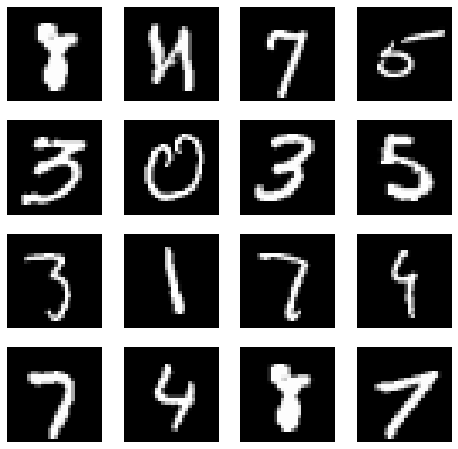

In [2]:
### Define MNIST data module

# Parameters dictionary
data_parameters = {
    "data_dir" : "MNIST",
    "batch_size" : 100,
}

# Create a dataset using pytorch_lighning data module
dm = MNISTDataModule(data_parameters)
dm.prepare_data()
dm.setup()

# Plot Mnist
figure = plt.figure(figsize=(8, 8))
cols, rows = 4,4

batch, label = next(iter(dm.train_dataloader()))

for i in range(1,cols * rows+1):
    sample_idx = torch.randint(len(batch), size=(1,)).item()
    img = batch[sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.axis("off")
    plt.imshow(img.squeeze(), cmap="gray")
plt.show()

## Define the network

In [3]:
# Define the pytorch_lightning networks
parameters1 = {
    "act" : "ReLU", 
    "optimizer" : "Adam", 
    "loss_fn" : "CrossEntropyLoss",
    "lr" : 1e-3, 
    "L2_reg" : 0.0, 
    "drop_p" : 0.1,
}

parameters2 = {
    "act" : "ReLU", 
    "optimizer" : "RMSprop", 
    "loss_fn" : "CrossEntropyLoss",
    "lr" : 1e-3, 
    "L2_reg" : 0.0, 
    "drop_p" : 0.1,
}

parameters3 = {
    "act" : "ReLU", 
    "optimizer" : "SGD", 
    "loss_fn" : "CrossEntropyLoss",
    "lr" : 1e-3, 
    "L2_reg" : 0.0, 
    "drop_p" : 0.1,
}


torch.manual_seed(0)
net = ConvNet(parameters1)

# Define an early stopping method
es = EarlyStopping(monitor = "val_loss")

# Define the trainer
num_epochs = 20
trainer = Trainer(
    gpus=1,
    max_epochs= num_epochs,
    progress_bar_refresh_rate=2,
    callbacks = [es],
)


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs


Network initialized


## Training

In [ ]:
### Training with early stopping

# Concatenate all dataset
data_set = ConcatDataset([dm.train_dataloader().dataset,
                              dm.val_dataloader().dataset,
                              dm.test_dataloader().dataset])


trainer.fit(net, dm)





In [ ]:
net.val_loss

In [ ]:
### Save network parameters
### Save the network state
# The state dictionary includes all the parameters of the network
net_dict = { "state" : net.state_dict(),
            "parameters" : parameters1}
# Save the state dict to a file
torch.save(net_dict,'ConvNet_parameters.torch')
print(net_dict["parameters"])

In [ ]:
### Reload the network state
# First initialize the network (if not already done)


net = ConvNet(init_par1)

net.to(device)
# Load the state dict previously saved
net_state_dict = torch.load('ConvNet_parameters.torch')
# Update the network parameters
net.load_state_dict(net_state_dict)

In [ ]:
### Save losses and accuracy: network 1

train_loss_net1 = [np.mean(net.train_loss[i*100:100*i+99]) for i in range(49)] 
val_loss_net1 = [np.mean(net.val_loss[i*20:20*i+19]) for i in range(49)] 
val_acc_net1 = [np.mean(net.val_acc[i*20:20*i+19]) for i in range(49)] 

In [ ]:
### Save losses and accuracy: network 2

train_loss_net2 = [np.mean(net.train_loss[i*100:100*i+99]) for i in range(49)] 
val_loss_net2 = [np.mean(net.val_loss[i*20:20*i+19]) for i in range(49)] 
val_acc_net2 = [np.mean(net.val_acc[i*20:20*i+19]) for i in range(49)] 

In [ ]:
### Save losses and accuracy: network 2

train_loss_net3 = [np.mean(net.train_loss[i*100:100*i+99]) for i in range(49)] 
val_loss_net3 = [np.mean(net.val_loss[i*20:20*i+19]) for i in range(49)] 
val_acc_net3 = [np.mean(net.val_acc[i*20:20*i+19]) for i in range(49)] 

In [ ]:
# Plot train losses
plt.figure(figsize=(12,8))
plt.semilogy(train_loss_net1, label='Adam')
plt.semilogy(train_loss_net2, label='RMSprop')
plt.semilogy(train_loss_net3, label='SGD')
plt.xlabel('Epoch')
plt.ylabel('Train loss')
plt.grid()
plt.legend()
plt.show()

In [ ]:

# Plot validation losses
plt.figure(figsize=(12,8))
plt.semilogy(val_loss_net1, label='Adam')
plt.semilogy(val_loss_net2, label='RMSprop')
plt.semilogy(val_loss_net3, label='SGD')
plt.xlabel('Epoch')
plt.ylabel('Validation loss')
plt.grid()
plt.legend()
plt.show()

In [ ]:
# Plot test accuracy

plt.figure(figsize = (12,8))
plt.plot(val_acc_net1, label = "Adam")
plt.plot(val_acc_net2, label = "RMSprop")
plt.semilogy(val_acc_net3, label='SGD')
plt.xlabel('Epoch')
plt.ylabel('Classification accuracy (%)')
plt.grid()
plt.legend()
plt.show()


In [ ]:
# Access metrics
trainer.callback_metrics
# Start tensorboard.
%load_ext tensorboard
%tensorboard --logdir lightning_logs/

## Hyperparameters optimization

In [4]:
### Define the objective function

def objective(trial):

    
    # Generate the optimizers.
    optimizer_name = trial.suggest_categorical("optimizer", ["Adam", "RMSprop", "SGD"])
    lr = trial.suggest_float("lr", 1e-5, 1e-1, log=True)
    
    parameters = {
    "act" : "ReLU", 
    "optimizer" : optimizer_name, 
    "loss_fn" : "CrossEntropyLoss",
    "lr" : lr, 
    "L2_reg" : 0.0, 
    "drop_p" : 0.1,
}
    
    # Generate the model.
    model = ConvNet(parameters)

    
    trainer.fit(model, dm)
    
    
    return np.mean[model.val_loss[-100:-1]]




In [5]:

study = opt.create_study(direction="minimize")
study.optimize(objective, n_trials=100)

   

[I 2021-08-31 11:25:13,295] A new study created in memory with name: no-name-d750050d-b93b-4da5-b616-b9f1ba967760
/home/alberto/anaconda3/lib/python3.8/site-packages/pytorch_lightning/core/datamodule.py:423: LightningDeprecationWarning: DataModule.setup has already been called, so it will not be called again. In v1.6 this behavior will change to always call DataModule.setup.
  rank_zero_deprecation(
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Network initialized



  | Name    | Type             | Params
---------------------------------------------
0 | loss_fn | CrossEntropyLoss | 0     
1 | cnn     | Sequential       | 13.2 K
2 | lin     | Sequential       | 67.0 K
---------------------------------------------
80.2 K    Trainable params
0         Non-trainable params
80.2 K    Total params
0.321     Total estimated model params size (MB)


Validation sanity check: 0it [00:00, ?it/s]

/home/alberto/anaconda3/lib/python3.8/site-packages/pytorch_lightning/trainer/data_loading.py:105: UserWarning: The dataloader, val dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/home/alberto/anaconda3/lib/python3.8/site-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)
/home/alberto/anaconda3/lib/python3.8/site-packages/deprecate/deprecation.py:115: LightningDeprecationWarning: The `accuracy` was deprecated since v1.3.0 in favor of `torchmetrics.functional.classificati

Training: -1it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

[W 2021-08-31 11:25:54,683] Trial 0 failed because of the following error: TypeError("'function' object is not subscriptable")
Traceback (most recent call last):
  File "/home/alberto/anaconda3/lib/python3.8/site-packages/optuna/study/_optimize.py", line 213, in _run_trial
    value_or_values = func(trial)
  File "/tmp/ipykernel_15309/4053391190.py", line 26, in objective
    return np.mean[model.val_loss[-100:-1]]
TypeError: 'function' object is not subscriptable


TypeError: 'function' object is not subscriptable

## Save and load model

In [ ]:
### Save network parameters
### Save the network state
# The state dictionary includes all the parameters of the network
net_dict = { "state" : net.state_dict(),
            "parameters" : parameters1}
# Save the state dict to a file
torch.save(net_dict,'ConvNet_parameters.torch')
print(net_dict)

In [ ]:
### Reload the network state
# First initialize the network (if not already done)

p = 0.1
net = ConvNet( p)

net.to(device)
# Load the state dict previously saved
net_state_dict = torch.load('ConvNet_parameters.torch')
# Update the network parameters
net.load_state_dict(net_state_dict)

# Network analysis

## Accuracy
    
    

In [ ]:
### Test the network on test dataset to check accuracy on mnist classification
def my_accuracy(network, device, dataloader):
    # Set evaluation mode
    network.eval()

    total = 0
    correct = 0
    mismatched = []
    
    with torch.no_grad():
        for  (x_batch, label_batch) in dataloader:
                
            # Move to device
            x_batch = x_batch.to(device)
            label_batch = label_batch.to(device)

            # Forward pass
            out = network(x_batch)
            
            out = out.squeeze()

            # Apply softmax 
            m = nn.Softmax(dim=0)
            out_soft = m(out)

           
            # Take the prediction
            predicted = out_soft.detach().cpu().argmax().item()

            # True value
            true = label_batch.detach().cpu().item()

            if predicted==true:
                correct += 1
            else:
                mismatched.append((x_batch.detach().cpu().numpy(), predicted, true))
                                  
            total += 1

    return mismatched, 100.0*correct/total

In [ ]:

mismatched, acc = my_accuracy(net, device = "cpu")
print("Test accuracy: ", acc, "%")

### Plot mismatched numbers


In [ ]:


# Plot Mismatched numbers
figure = plt.figure(figsize=(8, 8))
cols, rows = 4,4


for i in range(rows*cols):
    img = mismatched[i][0]
    
    figure.add_subplot(rows, cols, i+1)
    plt.axis("off")
    plt.imshow(img.squeeze(), cmap="gray"  )
    plt.title("Predicted: "+str(mismatched[i][1]))
plt.show()

### Confusion matrix

## Network parameters 

In [ ]:
# Access convolution network parameters

dense_weight = net.lin[0].weight.data.cpu().numpy()
dense_bias = net.lin[0].bias.data.cpu().numpy()
out_weight = net.lin[3].weight.data.cpu().numpy()
out_bias = net.lin[3].bias.data.cpu().numpy()

### Convolution filtered images

In [ ]:
# Acces convolution filters
conv1 = net.cnn[0].weight.data.cpu()
conv2 = net.cnn[4].weight.data.cpu()

In [ ]:
### First convolution filter
fig = plt.figure(figsize=(8, 8))
cols, rows = 4,4

# Take an image and apply convolution
img, label = train_data[0]
img = F.conv2d(img.unsqueeze(dim=0), conv1)

# Plot filtered images

for i in range(16):
    fig.add_subplot(rows, cols, i+1)
    plt.axis("off")
    #plt.title("Filter %d" %(i+1))
    plt.imshow(img.squeeze().numpy()[i], cmap="gray")
    
plt.tight_layout()
plt.show()




In [ ]:
### Second convolution filter
fig = plt.figure(figsize=(8, 8))
cols, rows = 8,4

# Take an image and apply convolution
img, label = train_data[9]
img = F.conv2d(img.unsqueeze(dim=0), conv1)
img = F.relu(img)
img  = F.max_pool2d(img, kernel_size = 2)
img = F.conv2d(img, conv2)

# Plot filtered images

for i in range(32):
    fig.add_subplot(rows, cols, i+1)
    plt.axis("off")
    #plt.title("Filter %d" %(i+1))
    plt.imshow(img.squeeze().numpy()[i], cmap="gray")
    
plt.tight_layout()
plt.show()